# Как люди распознают музыку?



*   Вибрация молекул воздуха (звуковые волны)
*   Детекция звуковых волн внешним ухом
*   Преобразование звуковых волн в звуковые сигналы
*   Отправка сигналов через слуховые нервы в мозг

![alt text](img/kulak.jpg)


# Как преобразовать аналоговый сигнал в цифровой?

* Аналоговый сигнал представляет собой непрерывную волну в виде синусоиды (изображена ниже), и может варьироваться по силе сигнала (амплитуде) или частоте (времени).

* Цифровой сигнал двоичен (0 и 1) и, следовательно, не может принимать какие-либо дробные значения.

* Для получения цифровых сигналов из аналоговых применяют квантование. Компьютеры могут захватывать такие данные только в отдельные моменты времени. Скорость, с которой компьютер захватывает аудиоданные, называется частотой дискретизации.

* Например, если мы используем частоту дискретизации 44,1 кГц, это означает, что мы используем 44100 сэмплов (выборок) в секунду.

* Люди могут слышать звуки в диапазоне 0-140 дБ и 20-20000 Гц!

![alt text](img/low.jpg)

![alt text](img/high.jpg)


In [2]:
import os
import sys
import csv
import time
import scipy
import sklearn
import pathlib
import itertools
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display as ipd
import matplotlib.pyplot as plt

import librosa
import librosa.display

from keras import models
from keras import layers

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

Using TensorFlow backend.
/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


* Возьмем две мелодии из датасета GTZAN как массив сэмплов. Датасет GTZAN использовался в исследовании ["Musical genre classification of audio signals"](https://www.researchgate.net/publication/3333877_Musical_genre_classification_of_audio_signals_IEEE_Trans_Speech_Audio_Process)  (G. Tzanetakis, P. Cook). Датасет состоит из 1000 звуковых дорожек длиной 30 секунд и содержит 10 жанров: блюз, классика, кантри, диско, хип-хоп, джаз, регги, рок, метал и поп. В каждом жанре по 100 звуковых дорожек.
* Частота дискретизации - 22050 Гц.
* Возьмем по 5 секундных отрывков из этих мелодий


In [5]:
sampling_rate=22050

x_metal,sr=librosa.load("data/genres/metal/metal.00001.wav",sr=sampling_rate,mono=True,duration=5.0)
x_classical,sr=librosa.load("data/genres/classical/classical.00001.wav",sr=sampling_rate,mono=True,duration=5.0)

In [6]:
print("Массив сэмплов мелодии жанра metal:(размер={})\n{}:\n ".format(x_metal.shape,x_metal))
print("Массив сэмплов мелодии классического жанра:(размер={})\n{}".format(x_classical.shape,x_classical))

Массив сэмплов мелодии жанра metal:(размер=(110250,))
[ 0.1164856   0.1194458   0.12341309 ... -0.11724854 -0.07055664
  0.01409912]:
 
Массив сэмплов мелодии классического жанра:(размер=(110250,))
[-0.01138306 -0.00216675  0.01687622 ...  0.03826904  0.03649902
  0.03051758]


* Теперь мы имеем 110250 сэмплов с частотой дискретизации 22.05 KHz.
* Такой массив сэмплов у нас имеется для каждой мелодии.
* Каждый элемент массива - это сэмпл из сигнала.
* Получим графики для каждой мелодии.


Text(0.5, 1.0, 'Classical')

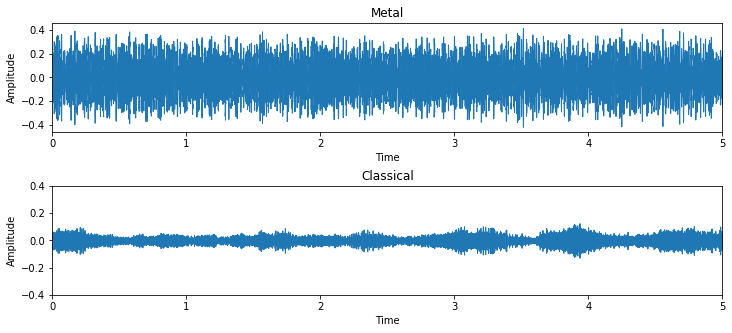

In [4]:
# Временная область
fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2, 1, 1)
plt.xlabel("Time")
plt.ylabel("Amplitude")
librosa.display.waveplot(x_metal,sampling_rate)
plt.title('Metal')

plt.subplot(2, 1, 2)
plt.ylim(-0.4,0.4)
plt.xlabel("Time")
plt.ylabel("Amplitude")
librosa.display.waveplot(x_classical,sampling_rate)
plt.title('Classical')

Послушаем мелодии

In [7]:
ipd.Audio(x_metal, rate=sampling_rate)

In [8]:
ipd.Audio(x_classical, rate=sampling_rate)

* Между двумя графиками заметны некоторые различия.
* Из таких графиков мы можем получить информацию только об амплитуде и времени.
* Мы не сможем многому научиться, имея только такую информацию.

**ЧТО ДЕЛАТЬ?**

* Применить преобразование Фурье.
* Анализировать всю песню целиком - не очень хороший способ.
* При обработке аудио принято работать с одним кадром за раз, используя фиксированный размер кадра и шаг (размер "скачка"). Кадры обычно выбираются длительностью от 10 до 100 мс.
* Мы вычисляем признаки из кадров.

**Некоторые понятия:**
* Длина кадра: количество сэмплов в кадре.
* Длина прыжка (шага): длина между кадрами (в сэмплах).
* В данном случае мы используем длину кадра - 2048 и длину прыжка - 512.
* Также эти значения являются стандартными для Librosa.

In [11]:
hop_size=512
frame_size=2048

In [12]:
#Сегментация
F=librosa.util.frame(x_metal,frame_length=frame_size,hop_length=hop_size)
x,y=F.shape

print("Кол-во кадров={} с длиной кадра={} для мелодии жанра metal".format(y,x))
print("Общее кол-во сэмплов = {}\n".format(y*x+hop_size))
print(F)

F2=librosa.util.frame(x_classical,frame_length=frame_size,hop_length=hop_size)
x2,y2=F2.shape

print("\nКол-во кадров={} с длиной кадра={} для мелодии классического жанра".format(y2,x2))
print("Общее кол-во сэмплов = {}\n".format(y2*x2+hop_size))
print(F2)

Кол-во кадров=212 с длиной кадра=2048 для мелодии жанра metal
Общее кол-во сэмплов = 434688

[[ 0.1164856  -0.00854492  0.01278687 ...  0.02215576 -0.09536743
  -0.11962891]
 [ 0.1194458  -0.15008545  0.01974487 ...  0.07736206 -0.12322998
  -0.18969727]
 [ 0.12341309 -0.16726685  0.03915405 ... -0.07910156 -0.1354065
  -0.10519409]
 ...
 [-0.16091919  0.0423584   0.01986694 ...  0.01937866  0.08105469
  -0.11630249]
 [-0.12545776 -0.01464844 -0.00216675 ...  0.05496216  0.152771
  -0.08566284]
 [-0.1257019  -0.10620117 -0.02612305 ...  0.08065796  0.09298706
  -0.06903076]]

Кол-во кадров=212 с длиной кадра=2048 для мелодии классического жанра
Общее кол-во сэмплов = 434688

[[-0.01138306  0.04495239 -0.07385254 ...  0.05505371  0.01245117
   0.04724121]
 [-0.00216675  0.02770996 -0.07080078 ...  0.06387329  0.0123291
   0.05960083]
 [ 0.01687622  0.02441406 -0.05963135 ...  0.06573486  0.02102661
   0.065979  ]
 ...
 [ 0.02804565 -0.03881836 -0.04690552 ...  0.01037598 -0.02514648
  -

**Можно ли сделать сегментацию другим способом?**
* Если мы сможем найти наиболее ценные точки в сигнале и выполнить сегментацию после этих точек, то сможем получить ценную информацию с меньшим количеством кадров. 

**Автоматическое обнаружение начала (Onset detection)**
* Автоматическое обнаружение музыкальных событий в аудиосигнале является одной из наиболее фундаментальных задач при поиске музыкальной информации. Здесь мы покажем, как обнаружить начало - тот самый момент, который отмечает начало переходной части звука, или самый ранний момент, когда переходный процесс может быть надежно обнаружен. Т.е. мы ищем места, где слышен (или начинается) внезапный звуковой взрыв, и отмечаем эти моменты времени.

![](img/onset.jpg)

In [13]:
#Onset Detection
onset_frames = librosa.onset.onset_detect(x_metal, sr=sampling_rate,hop_length=hop_size)
onset_times = librosa.frames_to_time(onset_frames)
x=onset_frames.size
print("Кол-во обнаруженных начал для мелодии жанра metal={}".format(x))
print(onset_frames)


onset_frames2 = librosa.onset.onset_detect(x_classical, sr=sampling_rate,hop_length=hop_size)
onset_times2 = librosa.frames_to_time(onset_frames2)
x2=onset_frames2.size
print("\nКол-во обнаруженных начал для мелодии классического жанра={}".format(x2))
print(onset_frames2)

Кол-во обнаруженных начал для мелодии жанра metal=33
[  3   7  11  19  27  35  44  48  51  60  68  77  84  93  98 101 110 118
 127 131 135 144 151 156 163 168 175 180 184 193 196 201 205]

Кол-во обнаруженных начал для мелодии классического жанра=23
[  5  18  26  46  50  56  69  80  83  91 106 113 122 128 134 146 157 166
 168 180 190 200 211]


Получим графики с найденными началами.

Text(0.5,1,'Classical')

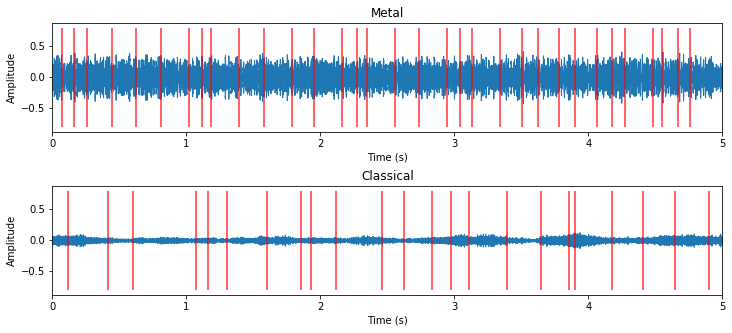

In [14]:
fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
librosa.display.waveplot(x_metal, sr=sampling_rate)
plt.vlines(onset_times, -0.8, 0.79, color='r', alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title('Metal')

plt.subplot(2,1,2)
librosa.display.waveplot(x_classical, sr=sampling_rate)
plt.vlines(onset_times2, -0.8, 0.79, color='r', alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title('Classical')

Давайте создадим звук щелчка и добавим этот звук к каждому началу сигнала.

In [15]:
clicks = librosa.clicks(frames=onset_frames, sr=sampling_rate, length=len(x_metal))
ipd.Audio(x_metal + clicks, rate=sampling_rate)

In [16]:
clicks = librosa.clicks(frames=onset_frames2, sr=sampling_rate, length=len(x_classical))
ipd.Audio(x_classical + clicks, rate=sampling_rate)

### Преобразование Фурье

Преобразование Фурье - одна из самых фундаментальных операций в прикладной математике и обработке сигналов. Она преобразует наш сигнал из временной области в частотную. В то время как во временной области наш сигнал выражается в виде последовательности сэмплов, в частотной области наш сигнал можно представить как суперпозицию синусоид различной величины, частоты и сдвига по фазе.

![alt text](img/time_and_freq.jpg)


![alt text](img/video.gif)


Давайте применим преобразование Фурье к каждой мелодии и получим спектры.

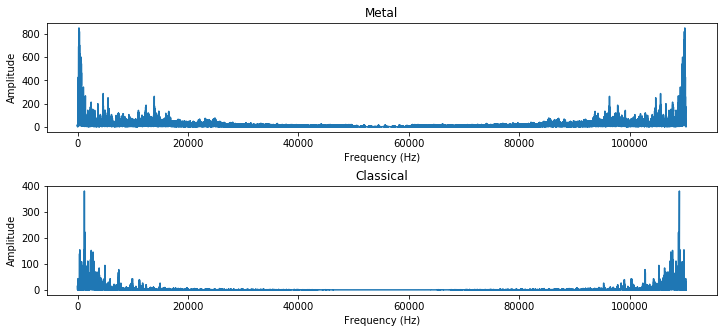

In [17]:
# Fourier Transform and Spectrum

fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
FFT_Metal=scipy.fft(x_metal)
FFT_Metal_Mag=np.absolute(FFT_Metal)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title('Metal')
plt.plot(FFT_Metal_Mag)

plt.subplot(2,1,2)
FFT_Classical=scipy.fft(x_classical)
FFT_Classical_Mag=np.absolute(FFT_Classical)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title('Classical')
plt.plot(FFT_Classical_Mag)

* Мы получили информацию о частотах сигнала.
* Но потеряли информацию о времени.
* Каким образом можно получить информацию о времени и частоте одновременно?

**Кратковременное преобразование Фурье**

* Музыкальные сигналы сильно нестационарны, т.е. их статистика со временем меняется. Было бы довольно бессмысленно вычислять спектр всей 10-минутной песни.
* С помощью STFT мы разбиваем сигнал на дискретные окна.
* Мы используем функцию окна, такую как Хеннинг, Хэмминг, полиномиальная функция ...
* Каждый сигнал в окне является стационарным сигналом.
* После того как мы применяем БПФ к каждому окну, мы получаем спектограмму сигнала.
* **Размер окна:** кол-во сэмплов в каждом окне.
* Давайте вычислим STFT для каждой мелодии и построим спектрограммы.

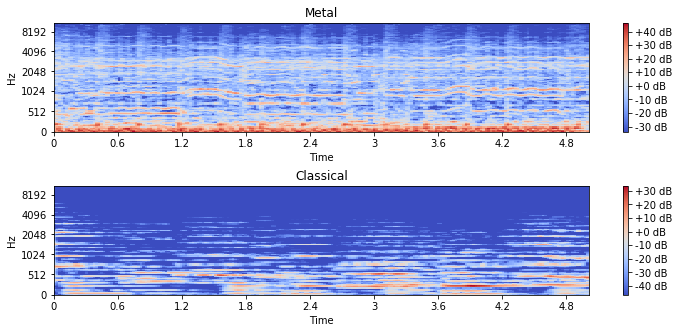

In [18]:
#Short-Time Fourier Transform and Spectogram

window_size=2048

fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
S = librosa.feature.melspectrogram(x_metal, sr=sampling_rate, n_fft=window_size)
logS = librosa.amplitude_to_db(S)
plt.title('Metal')
librosa.display.specshow(logS, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
S2 = librosa.feature.melspectrogram(x_classical, sr=sampling_rate, n_fft=window_size)
logS2 = librosa.amplitude_to_db(S2)
plt.title('Classical')
librosa.display.specshow(logS2, sr=sampling_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

Давайте добавим начала, которые мы обнаружили до этого, к спектрограммам.

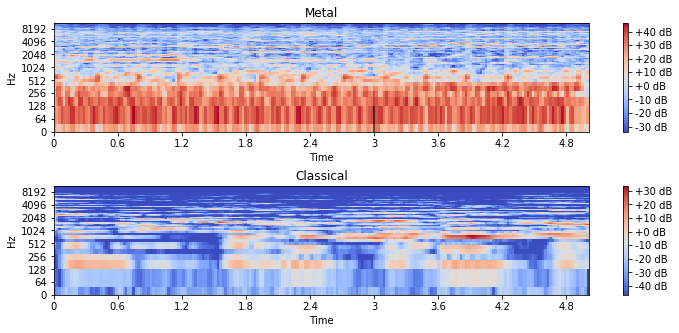

In [19]:
fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
S = librosa.feature.melspectrogram(x_metal, sr=sampling_rate, n_fft=window_size)
logS = librosa.amplitude_to_db(S)
plt.title('Metal')
librosa.display.specshow(logS, sr=sampling_rate, x_axis='time', y_axis='log')
plt.vlines(onset_frames, 0, logS.shape[0], color='k', alpha=0.8)
plt.colorbar(format='%+2.0f dB')

plt.subplot(2,1,2)
S2 = librosa.feature.melspectrogram(x_classical, sr=sampling_rate, n_fft=window_size)
logS2 = librosa.amplitude_to_db(S2)
plt.title('Classical')
librosa.display.specshow(logS2, sr=sampling_rate, x_axis='time', y_axis='log')
plt.vlines(onset_frames2, 0, logS.shape[0], color='k', alpha=0.8)
plt.colorbar(format='%+2.0f dB')

### Хромограмма


![alt text](img/chroma.jpg)

In [20]:
chroma_metal = librosa.feature.chroma_stft(x_metal, sr=sampling_rate, n_fft=window_size)
chroma_classical = librosa.feature.chroma_stft(x_classical, sr=sampling_rate, n_fft=window_size)

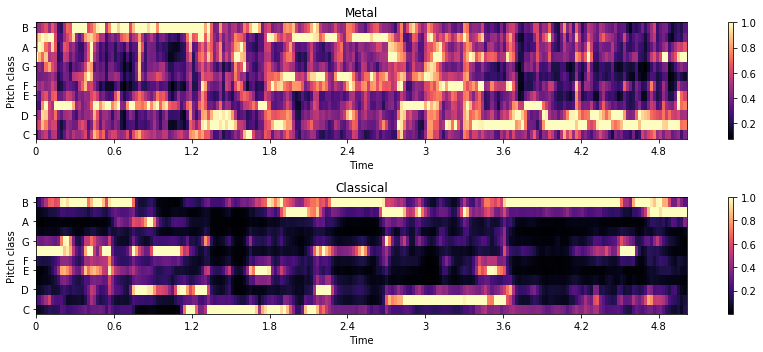

In [21]:
fig=plt.figure(figsize=(12,5))
fig.subplots_adjust(hspace=.5)

plt.subplot(2,1,1)
# plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_metal, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Metal')
plt.tight_layout()

plt.subplot(2,1,2)
# plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_classical, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Classical')
plt.tight_layout()

### Мила нравки ^_^

![](img/mila_nravke.jpg)

### Мел-кепстральные коэффициенты
https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

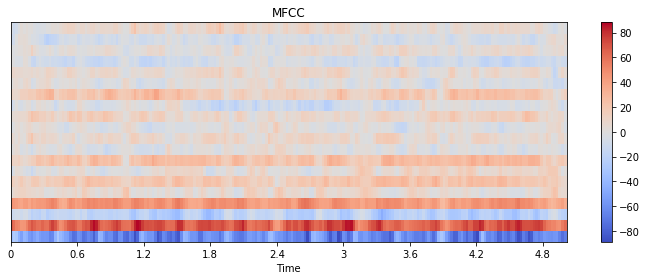

In [22]:
mfcc = librosa.feature.mfcc(y=x_metal, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

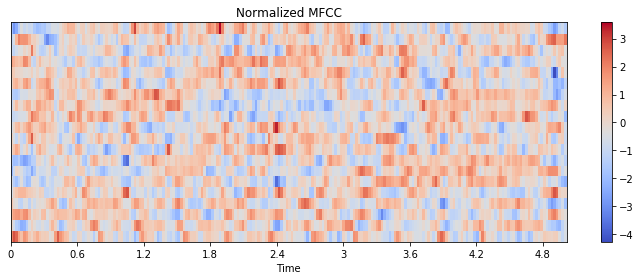

In [23]:
mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title('Normalized MFCC')
plt.tight_layout()

# Извлечение признаков


### Загрузка аудиофайла

In [27]:
songname = '/media/hdd/genres/classical/classical.00000.wav'
y, sr = librosa.load(songname, mono=True, duration=1)

### Воспроизведение

In [28]:
ipd.Audio(y, rate=sr)

### Визуализация аудиосигнала

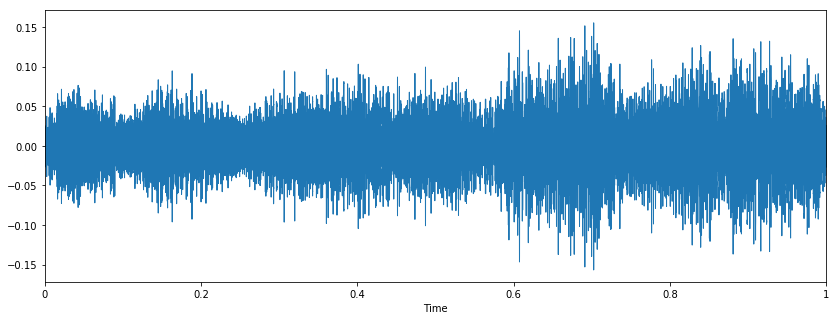

In [29]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)


### Beat tracking
https://www.analyticsvidhya.com/blog/2018/02/audio-beat-tracking-for-music-information-retrieval/

Отслеживание ритма - это задача идентификации и синхронизации с основным ритмическим импульсом музыкального произведения. В естественных условиях это происходит часто, например, когда люди стучат ногами, хлопают в ладоши или танцуют под музыку.

In [41]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
tempo, beats.shape[0]

/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/scipy/signal/signaltools.py:491: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[reverse].conj()
/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/scipy/signal/signaltools.py:251: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `a

(95.703125, 1)

### Частота перехода через ноль

Частота перехода через ноль - это кол-во изменений знака вдоль сигнала, т.е. скорость, с которой сигнал изменяется с положительного на отрицательный или обратно. Эта функция широко используется как для распознавания речи, так и в работе с музыкальной информацией. Обычно она имеет более высокие значения для таких жанров, как металл и рок.

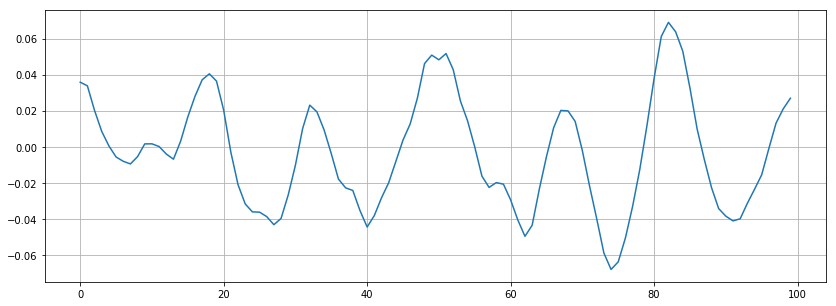

In [31]:
n0 = 8000
n1 = 8100
zcr = librosa.zero_crossings(y[n0:n1], pad=False)
plt.figure(figsize=(14, 5))
plt.plot(y[n0:n1])
plt.grid()

In [32]:
sum(zcr)

14

![](img/cross_zero.png)

### Спектральный центроид

Спектральный центроид указывает, где расположен «центр масс» для звука, и рассчитывается как средневзвешенное значение частот, присутствующих в звуке. Например, по сравнению с мелодией жанра blues, которая равномерна по всей длине, мелодия жанра metal имеет больше частот к концу. Таким образом, спектральный центроид для мелодии жанра blues будет находиться ближе к середине его спектра, а для песни жанра metal - ближе к концу.

librosa.feature.spectral_centroid() вычисляет спектральный центроид для каждого кадра в сигнале

![](img/spec_centr.png)

In [33]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]
spectral_centroids.shape

(44,)

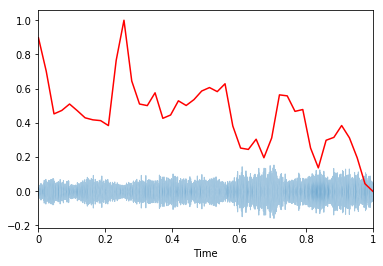

In [36]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

### Спектральный спад частоты

Спектральный спад частоты представляет собой частоту, ниже которой лежит указанный процент от общей спектральной энергии (например, 85%).

librosa.feature.spectral_rolloff вычисляет частоту спада для каждого кадра в сигнале

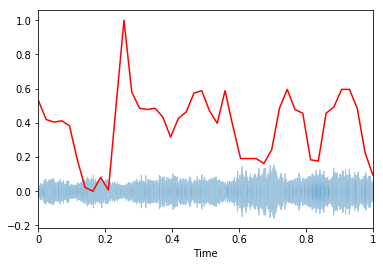

In [37]:
spectral_rolloff = librosa.feature.spectral_rolloff(y+0.01, sr=sr)[0]
librosa.display.waveplot(y, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

![](img/spectral_rolloff.png)

In [39]:
rmse = librosa.feature.rmse(y=y)
rmse

array([[0.0295148 , 0.02779332, 0.02758028, 0.02660531, 0.02396603,
        0.0261549 , 0.02720797, 0.02868035, 0.02803854, 0.02378822,
        0.02188734, 0.02258577, 0.02497736, 0.02799584, 0.03097254,
        0.03173987, 0.03259189, 0.03289819, 0.03113221, 0.03104206,
        0.02952143, 0.0292228 , 0.02936401, 0.02837761, 0.03098801,
        0.03437528, 0.03697773, 0.04065273, 0.04270351, 0.04396702,
        0.04400844, 0.04091001, 0.0373173 , 0.03362467, 0.03540838,
        0.04025453, 0.04339042, 0.04613125, 0.04588215, 0.04414008,
        0.04298718, 0.04162661, 0.04015082, 0.04049727]], dtype=float32)

### Среднеквадратичная энергия
https://musicinformationretrieval.com/energy.html

Вычислить среднеквадратичное значение (RMS) для каждого кадра либо из аудиосэмплов, либо из спектрограммы S.

Вычисление среднеквадратичного значения из аудиосэмплов происходит быстрее, так как не требует вычисления STFT. Однако использование спектрограммы даст более точное представление энергии во времени, потому что ее кадры могут быть оконными, поэтому предпочтительнее использовать S.

# Получение датафрейма с признаками


In [42]:
header = 'filename tempo beats chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()
data_path = '../data/data.csv' 
file = open(data_path, 'w', newline='')

In [43]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'/media/hdd/genres/{g}'):
        songname = f'/media/hdd/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rmse(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {tempo} {beats.shape[0]} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x
/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


# Выбор модели

In [44]:
def confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_cnf(model,dataset_x,dataset_y,GENRES):
    true_y=dataset_y
    true_x=dataset_x
    pred=model.predict(true_x)

    print("---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------\n")

    print("Real Test dataset labels: \n{}\n".format(true_y))
    print("Predicted Test dataset labels: \n{}".format(pred))

    cnf_matrix=sklearn.metrics.confusion_matrix(true_y,pred)
    plt.figure()
    a=confusion_matrix(cnf_matrix,classes=GENRES,title='Confusion matrix')

In [46]:
GENRES = os.listdir('data/genres')

## Разбиение на тренировочную и тестовую выборки

In [48]:
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)

In [49]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [50]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [52]:
print ("X_train shape: " + str(X_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("y_test shape: " + str(y_test.shape))

X_train shape: (800, 28)
y_train shape: (800,)
X_test shape: (200, 28)
y_test shape: (200,)


## Логистическая регрессия

In [53]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l1'}
accuracy : 0.63125


Training Score: 0.720
Test score: 0.610
---------------PERFORMANCE ANALYSIS FOR THE MODEL----------------

Real Test dataset labels: 
[2 7 6 7 3 1 5 7 8 6 3 7 2 2 5 9 6 6 6 0 1 3 2 7 2 6 3 5 3 3 1 6 5 8 7 8 3
 7 5 8 1 9 3 8 3 1 1 7 9 8 0 4 5 7 0 6 8 9 6 5 5 4 7 0 6 1 0 7 6 1 4 0 9 5
 1 5 1 9 7 5 0 6 5 2 1 2 1 1 0 4 9 2 9 0 4 0 0 0 0 6 7 6 8 5 0 2 0 2 3 9 2
 1 8 8 7 6 0 6 4 7 6 9 2 7 5 3 7 3 2 4 3 2 2 3 9 6 7 7 0 3 6 4 4 3 0 1 8 7
 3 2 7 8 2 9 5 2 4 0 8 3 3 1 6 6 7 7 1 0 7 1 8 4 1 2 4 9 0 5 7 1 6 9 5 5 9
 0 9 4 1 3 7 5 8 8 9 7 2 2 5 6]

Predicted Test dataset labels: 
[5 7 6 8 3 1 5 7 8 9 5 3 5 5 4 9 6 6 6 9 1 6 2 7 3 9 3 5 3 4 1 9 5 4 7 3 8
 7 9 4 1 4 3 8 3 1 1 4 7 2 4 7 8 7 5 6 7 5 6 5 5 2 7 5 6 1 5 3 6 1 7 0 9 5
 1 5 1 8 7 5 0 6 5 5 1 2 1 1 0 4 5 2 0 3 4 0 0 6 0 6 7 6 3 5 8 2 0 2 4 9 8
 1 8 4 7 6 0 6 4 7 6 2 2 7 1 3 7 3 0 4 6 2 8 3 3 2 7 4 6 2 6 4 4 3 8 1 2 7
 3 2 2 4 9 9 0 5 2 5 8 3 2 1 6 6 7 7 1 0 7 1 6 4 1 7 4 9 0 2 7 1 6 6 0 1 0
 6 4 8 1 3 7 1 8 8 8 7 2 0 5 6]


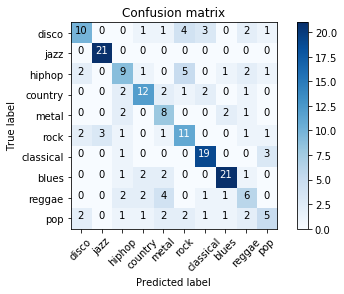

In [54]:
logistic_classifier = LogisticRegression(C=10, penalty='l1')
logistic_classifier.fit(X_train, y_train)
print("Training Score: {:.3f}".format(logistic_classifier.score(X_train,y_train)))
print("Test score: {:.3f}".format(logistic_classifier.score(X_test,y_test)))

plot_cnf(logistic_classifier,X_test,y_test,GENRES)

## KNN

## RandomForest

## SVM

## Neural network

In [55]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [56]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=128)

Epoch 1/20
800/800 [==============================] - 0s - loss: 2.2526 - acc: 0.1862     
Epoch 2/20
800/800 [==============================] - 0s - loss: 1.9835 - acc: 0.3788     
Epoch 3/20
800/800 [==============================] - 0s - loss: 1.7485 - acc: 0.4075     
Epoch 4/20
800/800 [==============================] - 0s - loss: 1.5391 - acc: 0.4537     
Epoch 5/20
800/800 [==============================] - 0s - loss: 1.3663 - acc: 0.5288     
Epoch 6/20
800/800 [==============================] - 0s - loss: 1.2341 - acc: 0.5750     
Epoch 7/20
800/800 [==============================] - 0s - loss: 1.1289 - acc: 0.6112     
Epoch 8/20
800/800 [==============================] - 0s - loss: 1.0499 - acc: 0.6412     
Epoch 9/20
800/800 [==============================] - 0s - loss: 0.9771 - acc: 0.6737     
Epoch 10/20
800/800 [==============================] - 0s - loss: 0.9165 - acc: 0.6962     
Epoch 11/20
800/800 [==============================] - 0s - loss: 0.8640 - acc: 0.7075   

In [57]:
test_loss, test_acc = model.evaluate(X_test,y_test)

 32/200 [===>..........................] - ETA: 0s

In [58]:
print('test_acc: ',test_acc)

test_acc:  0.615


### Валидация

In [59]:
x_val = X_train[:200]
partial_x_train = X_train[200:]

y_val = y_train[:200]
partial_y_train = y_train[200:]

In [60]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=30,
          batch_size=512,
          validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(X_test,y_test)

Train on 600 samples, validate on 200 samples
Epoch 1/30
600/600 [==============================] - 0s - loss: 2.2858 - acc: 0.1167 - val_loss: 2.1684 - val_acc: 0.2950
Epoch 2/30
600/600 [==============================] - 0s - loss: 2.1570 - acc: 0.3367 - val_loss: 2.0324 - val_acc: 0.3700
Epoch 3/30
600/600 [==============================] - 0s - loss: 2.0269 - acc: 0.3883 - val_loss: 1.8754 - val_acc: 0.4000
Epoch 4/30
600/600 [==============================] - 0s - loss: 1.8847 - acc: 0.3833 - val_loss: 1.7263 - val_acc: 0.4200
Epoch 5/30
600/600 [==============================] - 0s - loss: 1.7560 - acc: 0.3883 - val_loss: 1.6018 - val_acc: 0.4200
Epoch 6/30
600/600 [==============================] - 0s - loss: 1.6442 - acc: 0.4117 - val_loss: 1.4888 - val_acc: 0.4600
Epoch 7/30
600/600 [==============================] - 0s - loss: 1.5341 - acc: 0.4333 - val_loss: 1.4095 - val_acc: 0.5200
Epoch 8/30
600/600 [==============================] - 0s - loss: 1.4345 - acc: 0.4967 - val_l

In [62]:
print('test_acc: ',test_acc)

test_acc:  0.61


### Тестирование

In [63]:
predictions = model.predict_classes(X_test)

 32/200 [===>..........................] - ETA: 0s

In [64]:
print(classification_report(predictions, y_test))

             precision    recall  f1-score   support

          0       0.18      0.40      0.25        10
          1       1.00      0.84      0.91        25
          2       0.62      0.52      0.57        25
          3       0.50      0.62      0.56        16
          4       0.46      0.55      0.50        11
          5       0.55      0.42      0.48        26
          6       0.91      0.66      0.76        32
          7       0.81      0.79      0.80        28
          8       0.44      0.64      0.52        11
          9       0.41      0.44      0.42        16

avg / total       0.67      0.61      0.63       200



# FastAI

In [ ]:
!curl https://course-v3.fast.ai/setup/colab | bash

In [ ]:
!pip install torch torchvision

In [405]:
cmap = plt.get_cmap('inferno')

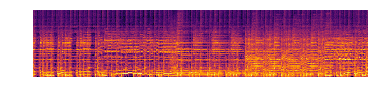

In [406]:
y , sr = librosa.load(songname, mono=True, duration=30)
spectogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=2048, hop_length=1024)
spectogram = librosa.power_to_db(spectogram, ref=np.max)
plt.axes().set_aspect('equal')
plt.imshow(spectogram, origin="lower", cmap=cmap);
plt.axis('off');

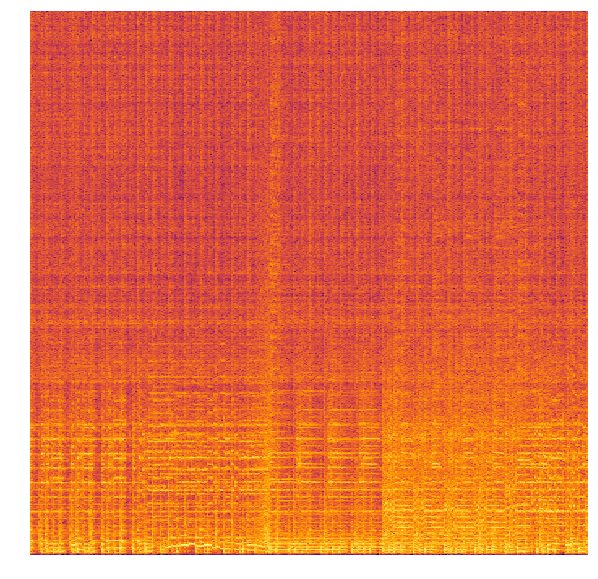

In [408]:
plt.figure(figsize=(10,10))
plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
plt.axis('off');
plt.savefig('demo.png')

In [414]:
plt.figure(figsize=(10,10))
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    pathlib.Path(f'../data/img_data/{g}').mkdir(parents=True, exist_ok=True)     
    for filename in os.listdir(f'../data/genres/{g}'):
        songname = f'../data/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
        plt.axis('off');
        plt.savefig(f'../data/img_data/{g}/{filename[:-3].replace(".", "")}.png')
        plt.clf()
    print(f'{g} done!')

The history saving thread hit an unexpected error (OperationalError('database or disk is full',)).History will not be written to the database.
blues done!
classical done!
country done!
disco done!


/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7674: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


hiphop done!
jazz done!
metal done!
pop done!
reggae done!
rock done!


<Figure size 720x720 with 0 Axes>

In [1]:
from fastai import *
from fastai.vision import *

## ResNet34

In [9]:
path = '../data/img_data/'
bs = 16
data = ImageDataBunch.from_folder(path, valid_pct=0.3, bs=bs)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (700 items)
x: ImageList
Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720)
y: CategoryList
hiphop,hiphop,hiphop,hiphop,hiphop
Path: /media/hdd/img_data;

Valid: LabelList (300 items)
x: ImageList
Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720),Image (3, 720, 720)
y: CategoryList
classical,classical,blues,country,reggae
Path: /media/hdd/img_data;

Test: None

In [10]:
print(data.classes)
len(data.classes),data.c

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


(10, 10)

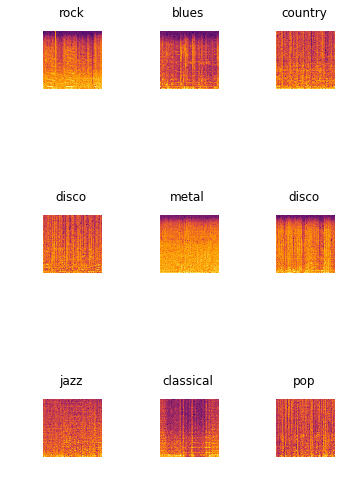

In [11]:
data.show_batch(rows=3, figsize=(5,8))

In [12]:
learner = create_cnn(data, models.resnet34, metrics=accuracy)

/home/abatar/miniconda3/envs/env_name/lib/python3.6/site-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [13]:
learner.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,2.364347,1.465971,0.486667,00:25
1,1.660012,0.950094,0.680000,00:24
2,1.300792,0.925688,0.673333,00:24
3,0.948913,0.858495,0.680000,00:23
4,0.752133,0.816420,0.723333,00:24
5,0.563325,0.745030,0.750000,00:25
6,0.447447,0.738897,0.750000,00:25
7,0.352679,0.754587,0.773333,00:24
8,0.306651,0.751144,0.750000,00:24
9,0.247737,0.746643,0.750000,00:24


In [14]:
learner.save('../models/resnet34_mtag75')

In [15]:
interp = ClassificationInterpretation.from_learner(learner)

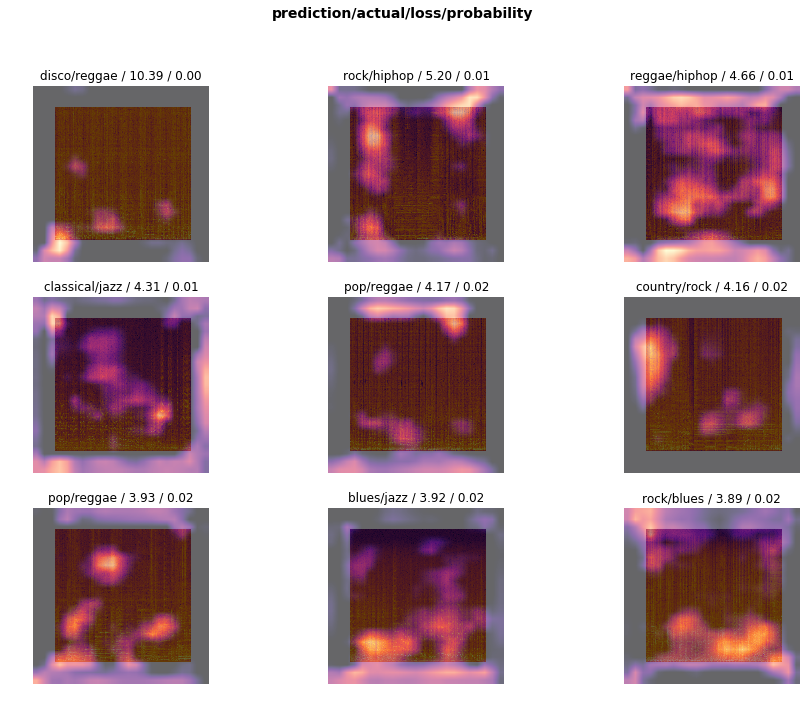

In [16]:
interp.plot_top_losses(9, figsize=(15,11))

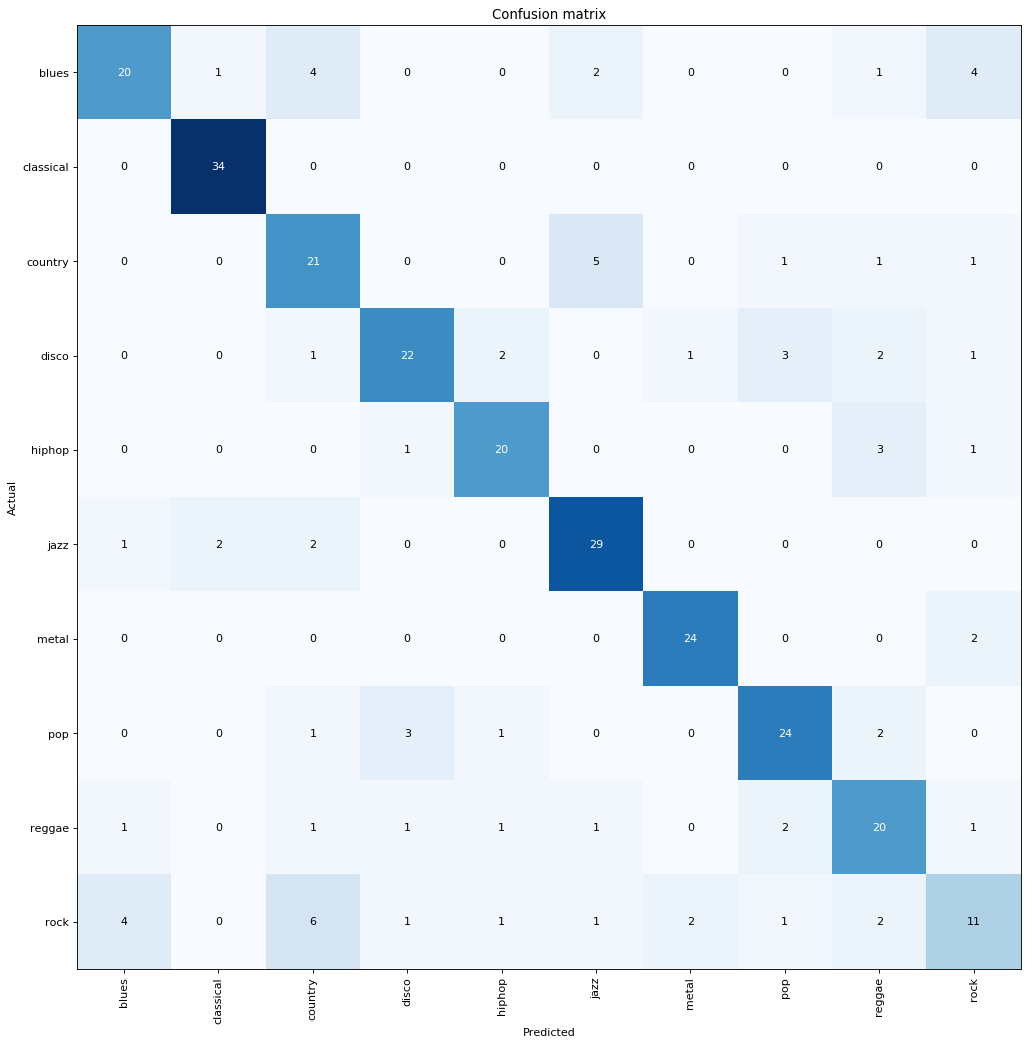

In [17]:
interp.plot_confusion_matrix(figsize=(13,13), dpi=80)

In [18]:
interp.most_confused(min_val=2)

[('rock', 'country', 6),
 ('country', 'jazz', 5),
 ('blues', 'country', 4),
 ('blues', 'rock', 4),
 ('rock', 'blues', 4),
 ('disco', 'pop', 3),
 ('hiphop', 'reggae', 3),
 ('pop', 'disco', 3),
 ('blues', 'jazz', 2),
 ('disco', 'hiphop', 2),
 ('disco', 'reggae', 2),
 ('jazz', 'classical', 2),
 ('jazz', 'country', 2),
 ('metal', 'rock', 2),
 ('pop', 'reggae', 2),
 ('reggae', 'pop', 2),
 ('rock', 'metal', 2),
 ('rock', 'reggae', 2)]

## ResNet50

# Миссия выполнена!




* Жанровая классификация – лишь одна из многих прикладных отраслей извлечения музыкальной информации.

* Мы разобрались, как организовывается работа с музыкальными сигналами на Python. Эти знания можно применить для решения множества задач: отслеживания ритма, создания музыки, рекомендательных систем, распознавания музыкальных инструментов и т. д.